# Seasonal adjustment - COVID-19 cases

Many time series exhibit regular seasonal patterns. The most obvious example is seasonal variation in temperatures, but seasonal data can be found in nearly every discipline. In this notebook series, we are examining data associated with COVID-19, and even a brief look at the data (shown a bit later) shows seasonal variation.

We will focus on reported numbers for new COVID-19 cases in the U.S. For this series, we might expect seasonal variation across the days of the week, and indeed [this paper](https://msystems.asm.org/content/5/4/e00544-20) suggests that this variation is due to both features of testing and reporting.

Seasonal variation is important for forecasting (since the seasonal variation is a key feature of the data and is also a part that can typically be forecasted relatively well), but it can make it more difficult to spot trends in the series. It is therefore common to "seasonally adjust" data, which typically involves estimating the variation that is due purely to seasonal effects, and then constructing a "seasonally adjusted" series that excludes that estimated seasonal variation.

As we will discuss here, this is closely related to time series decomposition, which refers to a family of approaches that attempt to identify separate and intuitive components that make up a given series, such as trend, seasonal, cyclical, and residual.

**Estimation of seasonal effects in Statsmodels**

In this notebook, we will show how to use the Python package [Statsmodels](https://www.statsmodels.org/stable/index.html) to estimate seasonal effects and to seasonally adjust data by considering the dataset with new COVID-19 cases. In particular, we will look at the following models:

- **Classical decomposition**: [API](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) for the `seasonal_decompose` function
- **Exponential smoothing models**: [API](https://www.statsmodels.org/devel/generated/statsmodels.tsa.exponential_smoothing.ets.ETSModel.html) and [example notebook](https://www.statsmodels.org/dev/examples/notebooks/generated/ets.html)
- **STL**: [API](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html) and [example notebook](https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html)
- **Unobserved components models**: [API](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html) and two example notebooks:
    + [Basic description](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_structural_harvey_jaeger.html) which includes a description of a "dummy variable"-like seasonal component.
    + ["Seasonality in time series data"](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_seasonal.html) includes a more in-depth description of the two models for the seasonal component (the "dummy variable"-like and "fourier"-like approaches).

**Useful resources**:

Of course there are a large number of references that deal with seasonal adjustment and time series decomposition. Here we provide a couple of the resource that are particularly relevant to the material as presented in this notebook (and see the "References" section at the end of this notebook for full citations).

- Hyndman and Athanasopoulos (2021) chapter on [time series decomposition](https://otexts.com/fpp2/decomposition.html) -- including [classical decomposition](https://otexts.com/fpp3/classical-decomposition.html) and [STL](https://otexts.com/fpp3/stl.html) -- and also their section on [exponential smoothing with a seasonal component](https://otexts.com/fpp3/holt-winters.html).
- Cleveland et al. (1990) paper introducing STL: [*STL: A Seasonal-Trend Decomposition Procedure Based on Loess*](https://search.proquest.com/openview/cc5001e8a0978a6c029ae9a41af00f21/1?pq-origsite=gscholar&cbl=105444)
- "An Introduction to State Space Time Series Analysis
" (Commandeur and Koopman, 2007) provides an introductory look at Unobserved Components models -- including those with a seasonal component -- along with their definition as a state space model.
- "Time Series Analysis by State Space Methods" (Durbin and Koopman, 2012) provides a detailed look at state space models, including Unobserved Components models and the two models for the seasonal component.

In [1]:
import pathlib

import numpy as np
import pandas as pd

import statsmodels.api as sm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()

## Data

Here we will use the [New York Times dataset](https://github.com/nytimes/covid-19-data), which we discussed in a previous notebook [001-etl-data-covid-19.ipynb](https://www.chadfulton.com/topics/001-etl-data-covid-19.html). In that notebook, we showed how to retrieve the data and store it as a parquet file. We'll now load the "new cases" column into a Pandas series.

**Note**: in this notebook, we'll only go through the end of 2020.

In [2]:
# Extract: download the data (here, load the CSV directly from the URL)
nytimes = pd.read_csv(
    'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv',
    index_col=['date'], parse_dates=['date']).asfreq(freq='D')

# Transform: add new columns with useful transformations
nytimes['new_cases'] = nytimes['cases'].diff()
nytimes['new_cases_ma7'] = nytimes['new_cases'].rolling(7).mean()

anomalous_dates = ['2020-09-21', '2020-11-26', '2020-12-11', '2020-12-25']
nytimes['anomaly'] = False
nytimes.loc[anomalous_dates, 'anomaly'] = True

# Load: save dataset as "us.parquet"
nytimes_path = pathlib.Path('./data/nytimes/')
nytimes_path.mkdir(parents=True, exist_ok=True)
nytimes.to_parquet(nytimes_path / 'us.parquet')

In [3]:
# Read the data from the Parquet file into a DataFrame
data = pd.read_parquet('./data/nytimes/us.parquet', columns=['new_cases'])

# Subset to the date range and column that we want
new_cases = data.loc['2020-04-01':, 'new_cases']

**Setting the frequency of the data**

As mentioned above, it is useful for what follows to indicate to Pandas the frequency of our dataset, which in this case is daily. Because we are using a date/time index, it can be difficult to "guess" the frequency, and so Pandas does not typically assign a frequency to our index by default. In the output below, notice that Pandas reports that `freq=None`.

In [4]:
print(new_cases.index)

DatetimeIndex(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10',
               ...
               '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17',
               '2023-03-18', '2023-03-19', '2023-03-20', '2023-03-21',
               '2023-03-22', '2023-03-23'],
              dtype='datetime64[ns]', name='date', length=1087, freq=None)


Even though we know that this is a daily dataset, Statsmodels does not have this information, because it relies on the `freq` of the index (although it will try to guess the frequency if it is not given).

One example of why this information is important arises when forecasting. If the last date in a dataset is "2021-01-01", but there is no information on the frequency of the data, Statsmodels can't be sure if the next forecast should be for the date "2020-01-01" (which would be appropriate if the data is daily), for the date "2020-02-01" (if the data is monthly), or something else (if the data is quarterly, annual, or some other frequency).

For these reasons, it is important when working with time series data to assign a frequency if possible. We can do that using Pandas' [`asfreq`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.asfreq.html) method.

In [5]:
# Let Pandas know that our data is observed at a daily frequency
new_cases = new_cases.asfreq('D')

# Notice that now we have `freq='D'`
print(new_cases.index)

DatetimeIndex(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10',
               ...
               '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17',
               '2023-03-18', '2023-03-19', '2023-03-20', '2023-03-21',
               '2023-03-22', '2023-03-23'],
              dtype='datetime64[ns]', name='date', length=1087, freq='D')


**Period of the seasonal component**

The key feature of seasonal patterns is that they regularly repeat. The number of observations before a given season reoccurs is called the **period** (note that sometimes different terminology is used; for example, in R's `forecast` package the term *frequency* is used in place of *period* - see [Rob Hyndman's description](https://robjhyndman.com/hyndsight/seasonal-periods/) for an explanation).

The period of the seasonal effect must generally be provided by the researcher as part of the model specification process, and it is important to think about what kinds of recurring patterns appear to be relevant for each particular dataset. At the same time, there are many "obvious" seasonal patterns that are based on the frequency of the data:

| Data frequency | Seasonal period |
|----------------|-----------------|
| Quarterly      | 4               |
| Monthly        | 12              |
| Weekly         | 52              |
| Daily          | 7 or 365        |

**Note**: in most cases, Statsmodels requires you to provide the period that you want to use for the data

**Note**: these are simply recommendations that are often useful - they are not the only possible choices. For example, some monthly datasets have seasonal patterns that repeat every six months, so a better choice of seasonal period would be 6 instead of 12.

**Note**: there are many additional complications that occur in real data. One such complication is when series have multiple seasonal patterns. For example, daily data might have a component that repeats every week as well as a component that repeats every year.

Since we're dealing with daily data and we're looking at weekly variation, it will be useful to define a mapping between the integer days of the week used by Pandas and human-readable names.

In [6]:
daysofweek = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
}

**Plotting the data**

The first step in considering seasonal adjustment (for example, identifying the period) is usually to visually examing the series to see if there appear to be noticeable seasonal flucations. We'll do that now.

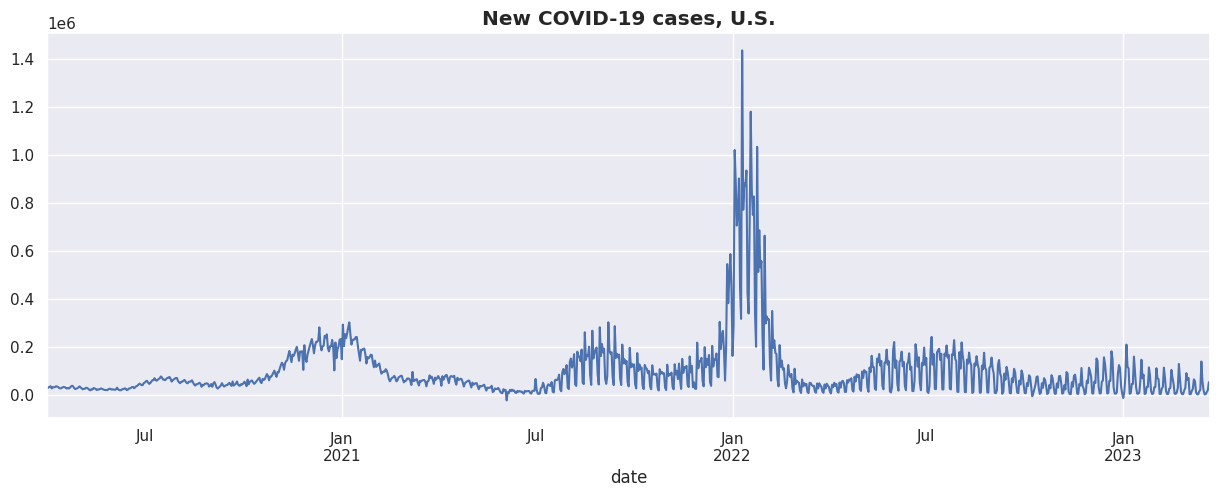

In [7]:
ax = new_cases.plot(figsize=(15, 5))
ax.set_title('New COVID-19 cases, U.S.', fontsize='large', fontweight='bold');

**Seasonality in the data**

Three features stand out from the figure above:

1. From even a quick look, it is pretty clear that there is a seasonal component to this series, since there are repeating peaks and troughs that reoccur about every week. This suggests that we should consider setting the **period equal to 7**.
2. A closer look reveals that the seasonal variations are weaker at the beginning of the sample, and become stronger as time progresses.
3. There are several notable outliers corresponding to Thanksgiving and Christmas. The existence of these events can hamper the identification of the seasonal component, so when possible we will try to account for them.

The first of these simply confirms that seasonal adjustment may be a desirable step in analysis. The second suggests that the seasonal component is changing over time, and we will need to take that into account in our analysis.

For this dataset, it seems likely that any seasonal variation that is driven by societal factors -- such as if people exhibit different behavior on the weekend versus the weekdays -- will affect the number of new cases *proportionally*. That is to say, if it is easier to get tested for COVID on the weekends, then we would expect to see a proportional increase in new cases detected on the weekends (or possibly at the beginning of the week, if test results take time to come back).

For example, suppose that people were 20% more likely to get tested for COVID on the weekend days. Then consider two different scenarios:

1. If 10 people got tested on a typical weekday, we would expect 12 people to get tested on the weekend, so that the seasonal effect would be an **additional 2 people tested**
2. If 100 people got tested on a typical weekday, we would expect 120 people to get tested on the weekend, so that the seasonal effect would be an **addtional 20 people tested**

Under this kind of assumption, the magnitude of the seasonal effect would vary with the level of the series, and we should consider a **multiplicative** model of seasonal adjustment, rather than an additive model.

**Transforming the data**

We have decided that for the new cases data that we are considering here, a multiplicative model of seasonality is more appropriate. In practice, more time series models are set up to work with additive models than with multiplicative models. Because of this, in this example we will apply a log transformation to the data (or more generally we could consider a Box-Cox transformation). We will then be able to use additive seasonal adjustment methods on the transformed data that will correspond to multiplicative seasonal adjustment on the original dataset.

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


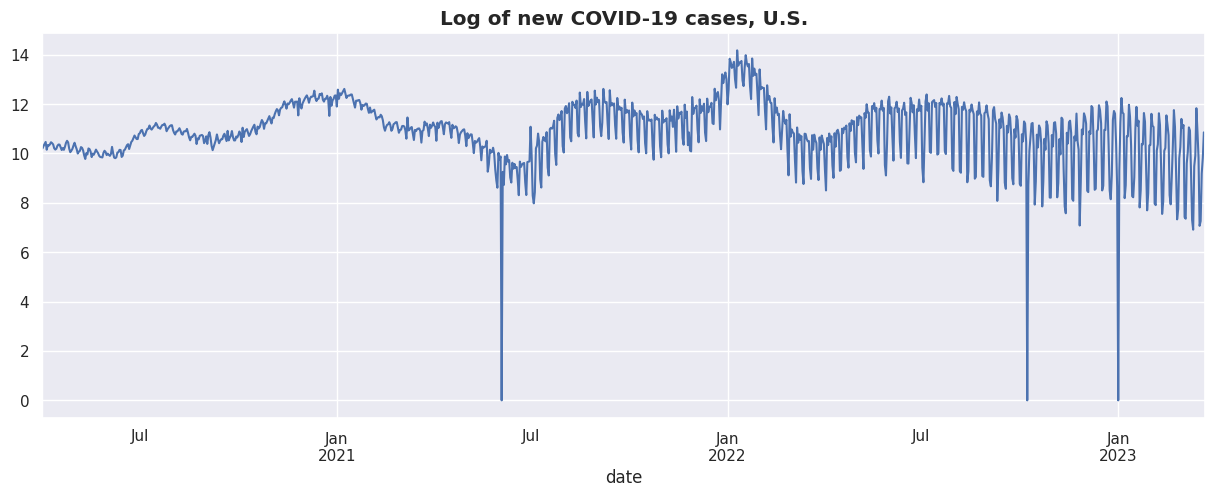

In [8]:
# Construct the log-transformed analysis dataset
# Replace zeros with a small number before taking the log
log_new_cases = np.log(new_cases.replace(0, np.nan)).fillna(0)

# Plot the transformed series to check if it has addressed our concern about changing seasonal factors
ax = log_new_cases.plot(figsize=(15, 5))
ax.set_title('Log of new COVID-19 cases, U.S.', fontsize='large', fontweight='bold');

The new graph shows that we have retained the clear seasonal variation in the data, but now it appears to have a more-or-less magnitude over the sample, and so an additive decomposition on the transformed dataset is reasonable.

Note: this is not to say that this transformation has eliminated all changes in seasonal variation over time, and some of the models below are able to capture changes in seasonal variation over time better than others.

## Time series decomposition and seasonal adjusment

In this notebook, we will consider the following models of seasonal adjustment, using Statsmodels:

1. Classical decomposition
2. Regression (both dummy variable and harmonics approaches)
3. Exponential smoothing
4. STL
5. Unobserved components (both dummy variable and harmonics approaches)

Each of these approaches is related to the concept of **time series decomposition**, in which a time series is decomposed into a smooth trend component, a periodic seasonal component, and an irregular "residual" component

$$
y_t = \underbrace{\mu_t}_\text{trend} + \underbrace{\gamma_t}_\text{seasonal} + \underbrace{\varepsilon_t}_\text{residual}
$$


**Note**: this is an example of an "additive" decomposition, which is supported by all of the above models. Several also support a "multiplicative" form (see [here](https://otexts.com/fpp3/components.html) for a description of the difference), but not all of them do, which is why were are using the additive form here (see above for the discussion of use of the log transformation).

**Note**: additional components can be added to the time series decomposition, for a cyclical term or explanatory variables. The "Unobserved components" model supports these additions.

**Seasonal adjustment** can be thought of as estimating and removing the seasonal component, so that the **seasonally adjusted** time series would be

$$
\begin{aligned}
z_t & = y_t - \gamma_t \\
& = \mu_t + \varepsilon_t
\end{aligned}
$$

**Extension: handling outliers** The existence of outliers in the dataset can make it more difficult for these statistical models to correctly decompose the model. For example, in our dataset holidays can present a problem, if people are less likely to take tests on holidays or if fewer testing centers are open on those days. Thanksgiving, Christmas, and New Years Day are examples of holidays that occur during the date range we're considering here (and they are the three noticeable downward spikes in November and December).

In fact, these particular days represent a double problem, because Christmas and New Years Day fall on the same day of the week. Because we're trying to estimate weekly seasonal factors, some models may become confused by the downward spike that occurred on two consecutive Fridays at the end of 2020, and interpret that movement as part of the seasonal pattern.

To try to account for the outliers observed on Thanksgiving, Christmas, and New Year's Day, we will create a set of *indicator variables* that will essentially allow some of our seasonal adjustment methods to discount those observations. For models that support it, these will be included as explanatory variables, so that our decomposition will be of the form:

$$
y_t = \mu_t + \gamma_t + \underbrace{\beta_1 x_{1t}}_\text{Thanksgiving} + \underbrace{\beta_2 x_{2t}}_\text{Christmas} + \underbrace{\beta_3 x_{3t}}_\text{New Year's Day} + \varepsilon_t
$$

where each $x_{it}$ is a column of zeros, except for a $1$ on the day in question (for example, $x_{1t}$ would have a $1$ on 2020-11-26, and zeros everywhere else).

In [9]:
# Create a series of indicator variables for holidays
holidays = pd.DataFrame(np.zeros((len(log_new_cases), 3)),
                        index=log_new_cases.index,
                        columns=['thanksgiving', 'christmas', 'new_years'])
holidays.loc['2020-11-26', 'thanksgiving'] = 1.0
holidays.loc['2020-12-25', 'christmas'] = 1.0
holidays.loc['2021-01-01', 'new_years'] = 1.0

### Classical decomposition

Classical decomposition is a well-worn technique for constructing a trend and seasonal component for a time series. See, for example, section 1.5 of Brockwell and Davis (2010) or [section 3.4 of Hyndman and Athanasopoulos (2021)](https://otexts.com/fpp3/classical-decomposition.html).

It typically proceeds in three steps:

1. Estimate the **trend** component $(\mu_t)$ by applying a moving average (or double moving average, if the seasonal period is an even number).
2. Estimate the **seasonal** component $(\gamma_t)$ by computing the average value of the *detrended series* $w_t = y_t - \mu_t$
3. **Normalize** the seasonal factors
    - For an additive model, this means adjusting them to sum to zero
    - For a multiplicative model, this means adjusting them such that their product is equal to one

#### Classical decomposition in Statsmodels: `seasonal_decompose`

In statsmodels, classical decomposition can be performed using the function `sm.tsa.seasonal_decompose`. It returns [an object](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.DecomposeResult.html#statsmodels.tsa.seasonal.DecomposeResult) that exposes the components of the decomposition as attributes:

- `trend` - the estimated trend component, $\mu_t$
- `seasonal` - the estimated seasonal component, $\gamma_t$
- `resid` -  - the residual component, $\varepsilon_t$

It does not have a built-in attribute for the seasonally adjusted series (defined above to be $z_t = y_t - \gamma_t$), but we can easily create it.

In [10]:
# Perform classical seasonal decomposition
classical_res = sm.tsa.seasonal_decompose(log_new_cases)

# Extract the trend and seasonal components
classical_trend = classical_res.trend
classical_seasonal = classical_res.seasonal

# Construct the seasonally adjusted series
classical_adjusted = (log_new_cases - classical_res.seasonal).rename('seasonally adjusted')

**Notes about `seasonal_decompose`**:

- **Seasonal period**: `seasonal_decompose` supports a `period` argument, although it attempts to determine an appropriate period from the `freq` attribute, if available. In this case, we set `freq='D'`, so `seasonal_decompose` will automatically selection `period=7`. If we were not passing a Pandas object with a defined frequency, we would simply pass `period=7` as an argument to the `seasonal_decompose` function.
- **Endpoints**: By default, `seasonal_decompose` uses what is equivalent to a centered moving average, so that a few periods have `NaN` values at the endpoints of the sample (you can control this behavior using the `two_sided` argument, and you can automatically extrapolate values for the `NaN` values at the beginning and end using the `extrapolate_trend` argument).
- **Outliers**: It does not accept explanatory variables, so we cannot use the intervention "dummy variable" strategy to account for outliers, and it does not have any built-in mechanism to account for them.

#### Exploring the output

It is easiest to examine the output of the classical decomposition graphically.

First, we'll plot the original series $(y_t)$ and the extracted trend $(\mu_t)$. The trend is considerably smoother than the original series, and it also does not contain the noticeable seasonal fluctuations.

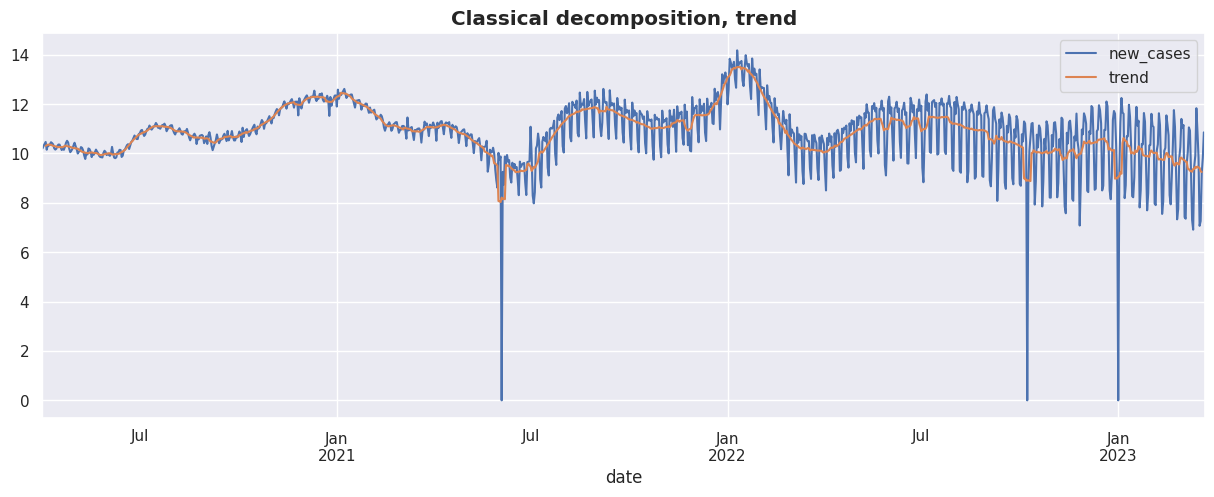

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))

log_new_cases.plot(ax=ax)
classical_trend.plot(ax=ax)
ax.set_title('Classical decomposition, trend', fontsize='large', fontweight='bold');
ax.legend();

Second, we'll plot the seasonally adjusted series $(z_t = y_t - \gamma_t)$ and, for reference, also include the estimated trend $(\mu_t)$.

The seasonally adjusted series contains more features of the original dataset than the smooth trend component (because it includes the irregular term $\varepsilon_t$), but the noticeable seasonable fluctuations have been largely eliminated.

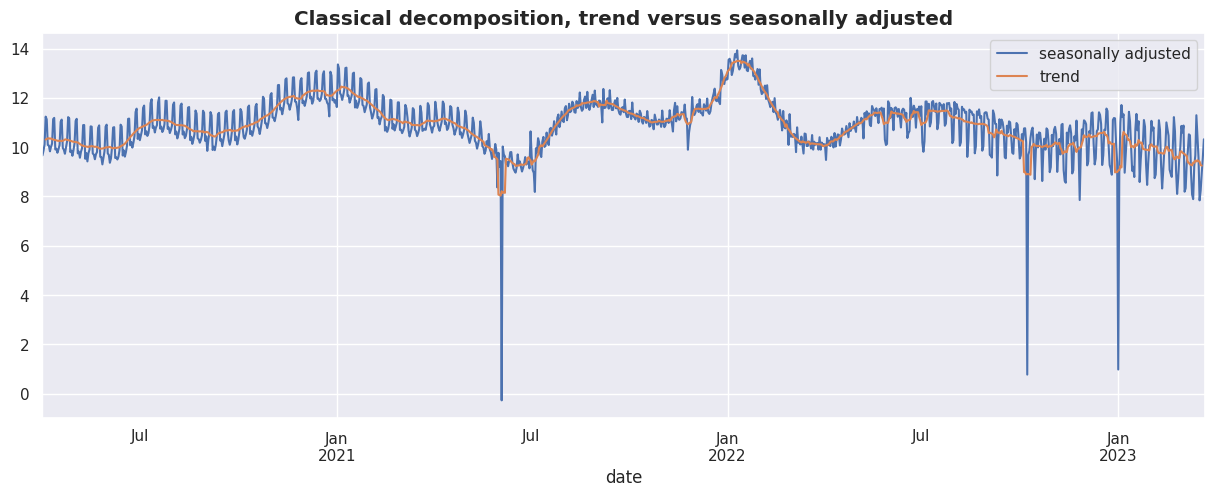

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))

classical_adjusted.plot(ax=ax)
classical_trend.plot(ax=ax)
ax.set_title('Classical decomposition, trend versus seasonally adjusted', fontsize='large', fontweight='bold');
ax.legend();

Finally, we may want to examine the estimated seasonal component. It is worthwhile to think about how to interpret the estimated seasonal effects. The interpretation mainly depends on whether the model in question is additive or multiplicative.

1. In **additive** models, the seasonal factors should be interpreted as the number of units typically seen in a given period above or below the average.
2. In **multiplicative** models, the seasonal factors should be interpreted as a percentage that a given period is typically above or below average.

Here, we used an *additive* model, but we performed the analysis on the `log` of the original dataset. To interpret the seasonal factors in terms of the original data, we can apply the `exp` function (which is the inverse of `log`) and then interpret these transformed seasonal factors in the same way that we would for a *multiplicative* model.

In [13]:
# Reverse the log transformation to get multiplicative seasonal factors
# that can be interpreted in terms of the number of new cases
orig_classical_seasonal = np.exp(classical_seasonal)

# Print the seasonal effects by the day of the week
# Note: in the classical decomposition, the seasonal effect
# does not vary over time, so while we are computing the "average"
# seasonal effect here, each week has exactly these seasonal factors
avg_classical_seasonal = orig_classical_seasonal.groupby(orig_classical_seasonal.index.dayofweek).mean()
avg_classical_seasonal.index = avg_classical_seasonal.index.map(daysofweek)
print(avg_classical_seasonal.round(2))

date
Monday       1.28
Tuesday      1.29
Wednesday    1.71
Thursday     1.55
Friday       1.31
Saturday     0.46
Sunday       0.38
Name: seasonal, dtype: float64


Here, the seasonal factor for Wednesday is about 1, meaning that the number of new cases on Wednesdays is about equal to the average new daily cases in a given week. Meanwhile, Friday has about 14% *more* new cases than average, and Sunday has about 14% *fewer* new cases than average.

In addition to looking at the values for the seasonal factors, there are also several plots that can be interesting:

- A plot of the seasonal effect over each of the days of the week.
- A time-series plot of the seasonal effects over the sample.

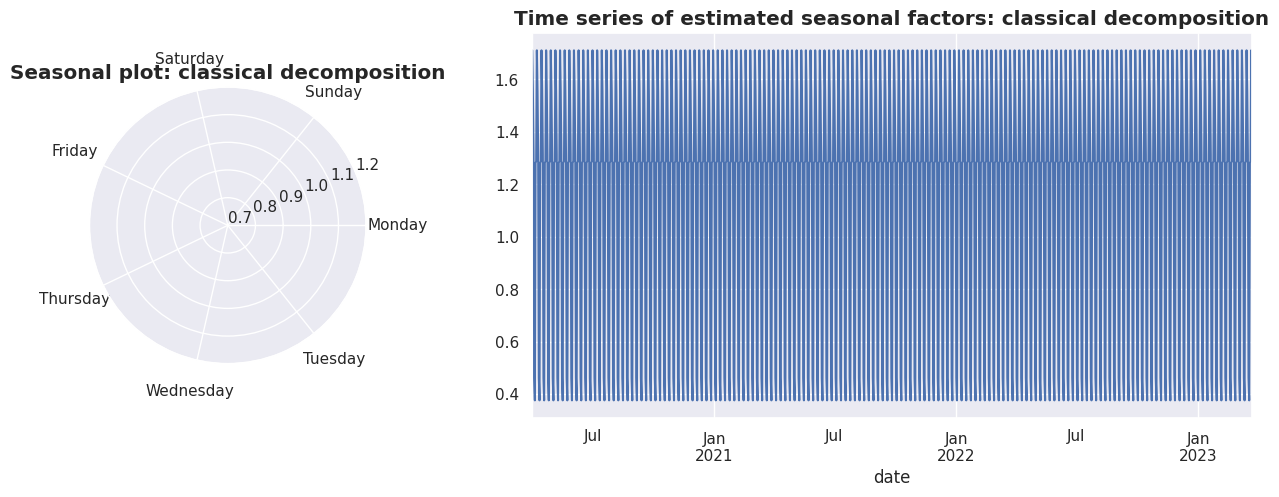

In [14]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection='polar')
ax2 = fig.add_subplot(gs[0, 1:])
gs.update(wspace=0.6)

# 1. Plot the seasonal factors by day of week
theta = (1 - (orig_classical_seasonal.index.dayofweek / 7)) * 2 * np.pi
ax1.plot(theta[:8], orig_classical_seasonal.values[:8])
ax1.set_xticks((1 - np.arange(7) / 7) * 2 * np.pi)
ax1.xaxis.set_tick_params(pad=10)
ax1.set_xticklabels(daysofweek.values())
ax1.set_ylim(0.7, 1.2)
ax1.set_title('Seasonal plot: classical decomposition', fontsize='large', fontweight='bold')

# 2. Plot the seeasonal factors as a time series
orig_classical_seasonal.plot(ax=ax2)
ax2.set_title('Time series of estimated seasonal factors: classical decomposition', fontsize='large', fontweight='bold');

The graph on the left shows what we suggested above, that Sundays tend to have fewer than average new cases while Fridays tend to have more new cases then average.

The graph on the right shows that in this model, the estimated seasonal pattern does not vary over time, but instead simply repeats throughout the sample.

#### Extra: manually computing the classical decomposition

We can also manually perform the classical decomposition procedure by following the three-step process described above.

In [15]:
# Step 1: Estimate the trend component with a moving average
# Note: use `center=True` to match the default behavior of
# `seasonal_decompose`
classical_manual_trend = log_new_cases.rolling(7, center=True).mean()

# Step 2: Estimate the seasonal component for each day of the week
# from the detrended series
classical_manual_detrended = log_new_cases - classical_manual_trend
dayofweek = pd.Series(pd.Categorical(log_new_cases.index.dayofweek), index=log_new_cases.index)
seasonal = classical_manual_detrended.groupby(dayofweek).mean()

# Step 3: Normalize the seasonals to sum to zero
seasonal -= seasonal.mean()

# The `seasonal` variable we just computed gives the seasonals for
# each day of the week; now we need to apply those to the actual
# days of the week in our sample to create a time series of seasonal
# factors.
classical_manual_seasonal = dayofweek.map(seasonal).astype(float)

/tmp/ipython-input-713897398.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal = classical_manual_detrended.groupby(dayofweek).mean()


We can easily check that these values are identical to those that were created using `seasonal_decompose`:

In [16]:
from numpy.testing import assert_allclose

# Check that the estimated trend is the same
assert_allclose(classical_manual_trend, classical_trend)

# Check that the estimated seasonals are the same
assert_allclose(classical_manual_seasonal, classical_seasonal)

**Note**: even though this creates the same values, it is recommended that `seasonal_decompose` be used for classical decomposition, becuase is much faster for long time series and it has additional options that can be useful.

### Regression-based seasonal estimation

Classical decomposition computes the seasonal effect by first smoothing the data with a moving average filter, and then taking averages for each day of the week from the detrended data.

We can extend the second step of this approach by using a regression on the detrended data, using either dummy variables or Fourier terms for the seasonal effects. If we only include these terms, then this does not provide any benefit over the original method of taking averages (in fact it gives identical results). However, through the regression-based approach we can include additional terms, such as the holiday intervention variables we defined above to account for the outliers.

Recall that the moving average filter created an estimate of the trend term $\mu_t$, and we were able to define the detrended data $w_t = y_t - \mu_t$. Now we will fit the regression

$$
w_t = \underbrace{\alpha}_\text{intercept} + \underbrace{\beta_1 x_{1t} + \beta_2 x_{2t} + \beta_3 x_{3t}}_\text{Outlier terms} + \sum_{i=1}^k \underbrace{g_i s_{it}}_\text{$i$th seasonal term} + \varepsilon_t
$$

to estimate the terms $\alpha, \beta_1, \beta_2, \beta_3, g_1, \dots, g_k$. The seasonal component is then estimated as

$$
\gamma_t = \sum_{i=1}^k g_i s_{it}
$$

**Setting up the regression**

The stacked regression equation across all observations has the form

$$w = \beta X + \varepsilon$$

where $w$ is the detrended series described above, $\beta = \begin{pmatrix}\alpha & \beta_1 & \beta_2 & \beta_3 & g_1 & \dots & g_k \end{pmatrix}$, and $X = \begin{bmatrix} \iota & x_1 & x_2 & x_3 & s_1 & \dots & s_k \end{bmatrix}$.

To estimate this, we need to construct the detrended series $w$ and the matrix $X$. It is straightforward to construct the detrended series:

In [17]:
classical_detrended = log_new_cases - classical_trend

Plotting the detrended series below, it still retains the noticeable seasonal fluctuations, but now it remains centered roughly at zero and does not rise and fall over the course of the sample.

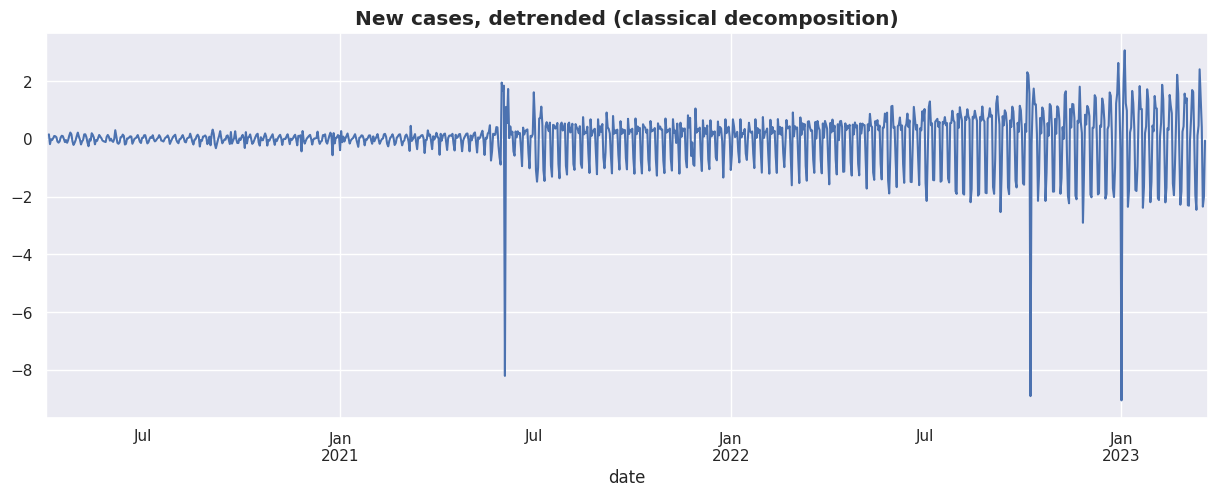

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))

classical_detrended.plot(ax=ax)
ax.set_title('New cases, detrended (classical decomposition)', fontsize='large', fontweight='bold');

The previous cell failed because the `classical_detrended` variable was not defined. This variable is created by subtracting the `classical_trend` from `log_new_cases`. We will define it now.

#### Seasonal dummy variables

The first regression-based approach models the seasonal components using dummy variables. In this case, we would include seven dummy variables, one for each day of the week. Then, for example, the dummy variable $s_1 = \text{Monday}$ would be equal to $1$ if the date fell on a Monday, and be equal to $0$ otherwise.

To get a sense of what the $X$ matrix should look like with these dummy variables, here are seven example rows:

$$
\begin{bmatrix}
1 & 0 & 0 & 0 & 1 & 0 & \dots & 0 \\
1 & 0 & 0 & 0 & 0 & 1 & \dots & 0 \\
\vdots & \vdots & & \vdots & & & \ddots & \\
1 & 0 & 0 & 0 & 0 & 0 & \dots & 1 \\
\end{bmatrix}
$$

The first column represents the intercept, so it is a vector of ones. The second, third, and fourth columns are the holiday dummy variables, so they have zeros in every position except for the row corresponding to the date of the corresponding holiday. The final seven columns are a set of dummy variables, one for each day of the week.

The remaining rows of $X$ are defined in the same way as these first seven.

To construct this matrix, we will separately create the various columns, and then concatenate them together. A couple of notes:

- We already created the `holidays` dummy variables, which we can use here
- We can use the Pandas [`get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) function to create a complete set of dummy variables based on the (integer) day of the week
- We can use the Statsmodels [`add_constant`](https://www.statsmodels.org/stable/generated/statsmodels.tools.tools.add_constant.html) function to prepend a column of ones for the intercept term.

In [19]:
# Pandas makes it easy to get a complete set of dummy variables for a given series
seasonal_dummies = pd.get_dummies(log_new_cases.index.dayofweek, dtype=float)

# Add human-readable columns and the date index
seasonal_dummies.columns = seasonal_dummies.columns.map(daysofweek)
seasonal_dummies.index = log_new_cases.index

# Construct the matrix
X = sm.add_constant(pd.concat([holidays, seasonal_dummies], axis=1))

# Display the output (just using astype(int) to make it easier to read the table)
X[:7].astype(int)

,const,thanksgiving,christmas,new_years,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
date,,,,,,,,,,,
2020-04-01,1,0,0,0,0,0,1,0,0,0,0
2020-04-02,1,0,0,0,0,0,0,1,0,0,0
2020-04-03,1,0,0,0,0,0,0,0,1,0,0
2020-04-04,1,0,0,0,0,0,0,0,0,1,0
2020-04-05,1,0,0,0,0,0,0,0,0,0,1
2020-04-06,1,0,0,0,1,0,0,0,0,0,0
2020-04-07,1,0,0,0,0,1,0,0,0,0,0


**Dummy variable trap**

As written above, the matrix $X$ has a problem, which is that it is subject to the [dummy variable trap](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)). The first column is perfectly collinear with the final seven columns. There are a number of easy ways to remedy this problem, including dropping either the intercept column or one of the columns including seasonal dummy variables.

In this case, however, there is a better way to proceed. Recall that in the original formulation of the classical decomposition, above, we had to normalize the seasonal effects to sum to zero in order to be able to interpret them appropriately. We can use [restricted least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares#Constrained_estimation) to incorporate this normalization constraint into the regression itself, and this will both make the estimates immediately interpretable and avoid the dummy variable trap.

We need to impose the restriction that:

$$g_1 + \dots + g_7 = 0$$

In practice, since we named our seasonal effects according to the day of the week, we will use the constraint:

`'Monday + Tuesday + Wednesday + Thursday + Friday + Saturday + Sunday = 0'`

Imposing this constraint has the same technical effect as dropping one of the seasonal dummy variable columns, but it makes the results easier to use and interpret on a practical basis because all of the columns remain in the model.

**Fitting a model with linear constraints in Statsmodels**

The basic [`OLS`](https://www.statsmodels.org/stable/regression.html) model in Statsmodels does not support restricted least squares, but we can use the [`GLM`](https://www.statsmodels.org/stable/glm.html) model  to fit it, using the [`fit_constrained`](https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.fit_constrained.html) method.

**Note**: recall that the moving-average method used to construct the classical trend resulted in NaN values at the endpoints of the sample. We can use the `missing='drop'` argument to automatically drop these rows.

In [20]:
# Construct the model
dummies_mod = sm.GLM(classical_detrended, X, missing='drop')

# Fit the model with the constraint that the seasonal effects sum to zero
seasonal_constraint = 'Monday + Tuesday + Wednesday + Thursday + Friday + Saturday + Sunday = 0'
dummies_res = dummies_mod.fit_constrained(seasonal_constraint)

The estimated regression coefficients $\hat \beta$ give the effects of the holiday outliers and seasonal components in terms of our log-transformed variable, but (as above) we can apply the `exp` operator to interpret them in terms of the original model.

In [21]:
print(np.exp(dummies_res.params).round(2))

const           1.00
thanksgiving    0.42
christmas       0.43
new_years       0.51
Monday          1.28
Tuesday         1.29
Wednesday       1.71
Thursday        1.56
Friday          1.32
Saturday        0.46
Sunday          0.37
dtype: float64


We can learn a couple of things from these parameters:

- The estimated coefficients for the dummy variables for the outlier observations describe how far below average the new case reports were on each holiday. On each day, new cases were 40-50% lower than average.
- After accounting for the outliers, the estimated seasonal effects were about the same, although the seasonal factor for Friday is even higher (likely because the negative outliers for Christmas and New Year's Day were pulling it down).

Finally, we can easily construct the time-series of these seasonal effects as

$$
\gamma_t = \sum_{i=1}^7 g_i s_{it}
$$

In [22]:
# Here we're using the matrix multiplication operator (@) to conveniently
# construct the sum above.
dummies_seasonal = seasonal_dummies @ dummies_res.params[seasonal_dummies.columns]

**Re-estimating the trend**

As an additional step, we could re-estimate the trend component now that we have an estimate of the effect of the outlier observations. To do so, we would apply the moving average smoother to the series excluding the regression effects just estimated.

In the graph below, it is clear that the outliers had a marked impact on the original estimated trend.

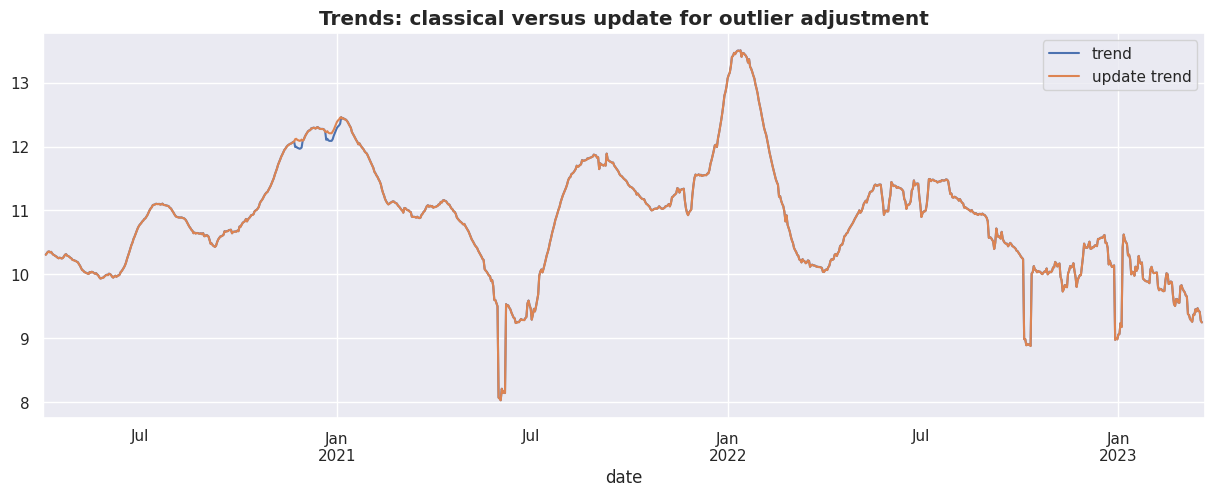

In [23]:
# Compute a version of the data, adjusted for outliers and seasonal effects
estimated_regression_effects = dummies_res.predict(X)
adjusted = log_new_cases - estimated_regression_effects

# Compute an updated trend estimate, using the adjusted data
updated_trend = adjusted.rolling(7, center=True).mean().rename('update trend')

# Graph the original and updated trend
fig, ax = plt.subplots(figsize=(15, 5))
classical_trend.plot()
updated_trend.plot()
ax.set_title('Trends: classical versus update for outlier adjustment', fontsize='large', fontweight='bold');
ax.legend();

**Iterating this process**

Of course, now that we have an updated trend estimate, we could re-estimate the outlier and seasonal effects using newly detrended data. One option would be to iterate until there were no further changes (to some tolerance) to the estimated trend, although we will not do that here.

#### Harmonic regression

As an alternative to the dummy variable approach, we could alternatively include Fourier series terms, which are periodic terms composed of sine and cosine waves that can model regular fluctuations, such as those from seasonal variation. We won't discuss these in much detail here; for specifics see [section 5.4 of Hyndman and Athanasopoulos (2021)](https://otexts.com/fpp2/useful-predictors.html#fourier-series).

However, we can easily implement in Statsmodels them using the [`DeterministicProcess`](https://www.statsmodels.org/stable/examples/notebooks/generated/deterministics.html) helper.

**Note**: In the dummy variable approach, we had to estimate six parameters (although we included seven dummy variables, the constraint meant that only six parameters were free to be estimated separately). An advantage of harmonic regression is that we can still capture seasonal effects with fewer parameters to be estimated. For example, by specifying `fourier=2`, we will only estimate four parameters.

In [24]:
# Construct the fourier terms using the DeterministicProcess helper
from statsmodels.tsa.deterministic import DeterministicProcess
det_proc = DeterministicProcess(log_new_cases.index, period=7, fourier=2)
fourier = det_proc.in_sample()

# Display the first 5 elements of the created Fourier terms
fourier.head().round(2)

,"sin(1,7)","cos(1,7)","sin(2,7)","cos(2,7)"
date,,,,
2020-04-01,0.00,1.00,0.00,1.00
2020-04-02,0.78,0.62,0.97,-0.22
2020-04-03,0.97,-0.22,-0.43,-0.90
2020-04-04,0.43,-0.90,-0.78,0.62
2020-04-05,-0.43,-0.90,0.78,0.62


Here, we will use the updated trend (that accounted for outlier effects) to construct an improved detrended series, before estimating the seasonal effects.

In [25]:
# Construct the newly detrended series using the updated trend
updated_detrended = log_new_cases - updated_trend

# Construct the X matrix for the harmonic regression approach
X = sm.add_constant(pd.concat([holidays, det_proc.in_sample()], axis=1))

# Construct and fit the harmonic regression model using the newly detrended series
# and, again, dropping the rows with missing values
harmonic_mod = sm.OLS(updated_detrended, X, missing='drop')
harmonic_res = harmonic_mod.fit()

Unlike with the dummy variable approach, the estimated parameters do not immediately give the seasonal effects. Instead, we will need construct the time series of seasonal factors as

$$
\gamma_t = \sum_{i=1}^4 g_i s_{it}
$$

In [26]:
# Here we're using the matrix multiplication operator (@) to conveniently
# construct the sum above.
harmonic_seasonal = fourier @ harmonic_res.params[fourier.columns]

To interpret the results and compare them to the classical decomposition, it will again be useful to referse the `log` transformation using the `exp` function.

In [27]:
# Reverse the log transformation to get multiplicative seasonal factors
# that can be interpreted in terms of the number of new cases
orig_harmonic_seasonal = np.exp(harmonic_seasonal)

# Print the seasonal effects by the day of the week
# Note: again, these don't actually vary over time, but just repeat
avg_harmonic_seasonal = orig_harmonic_seasonal.groupby(orig_harmonic_seasonal.index.dayofweek).mean()
avg_harmonic_seasonal.index = avg_harmonic_seasonal.index.map(daysofweek)
print(avg_harmonic_seasonal.round(2))

date
Monday       1.08
Tuesday      1.56
Wednesday    1.43
Thursday     1.78
Friday       1.25
Saturday     0.45
Sunday       0.42
dtype: float64


Now, we can compare these seasonal effects to those estimated from the classical decomposition. Although they give a similar picture of seasonality in reported new cases, there are some differences, including an even larger seasonal effect on Fridays with the harmonic regression approach.

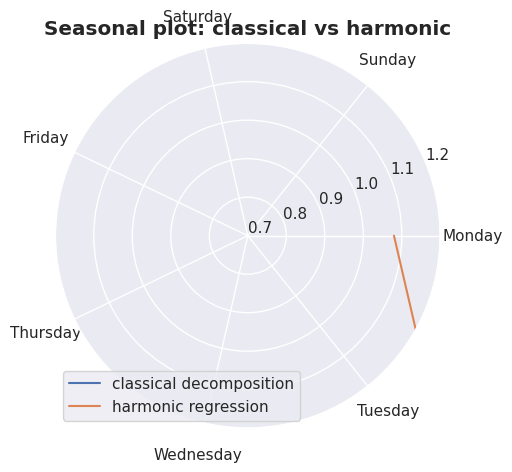

In [28]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(projection='polar')

# 1. Plot the seasonal factors by day of week
theta = (1 - (orig_classical_seasonal.index.dayofweek / 7)) * 2 * np.pi
ax1.plot(theta[:8], orig_classical_seasonal.values[:8], label='classical decomposition')

theta = (1 - (orig_harmonic_seasonal.index.dayofweek / 7)) * 2 * np.pi
ax1.plot(theta[:8], orig_harmonic_seasonal.values[:8], label='harmonic regression')
ax1.set_xticks((1 - np.arange(7) / 7) * 2 * np.pi)
ax1.xaxis.set_tick_params(pad=10)
ax1.set_xticklabels(daysofweek.values())
ax1.set_ylim(0.7, 1.2)
ax1.set_title('Seasonal plot: classical vs harmonic', fontsize='large', fontweight='bold')
ax1.legend(loc='lower left');

### Exponential smoothing

In the classical and regression-based decompositions, above, the process was somewhat ad-hoc: first the trend was estimated using a moving average, and then second, the seasonal factors were separately estimated on the residual (i.e. the detrended series). Exponential smoothing models provide a relatively simple way of estimating both the trend and seasonal factors simultaneously, in a single model. In addition, while the seasonal factors were not able to vary over time in the previous approaches, they can do so in exponential smoothing models.

**Note**: There are several implementations of exponential smoothing models in Statsmodels, and this can unfortunately be confusing.

- For most purposes, `sm.tsa.ETSModel` should be used. It is the newest model, and it is intended to eventually offer comprehensive support for exponential smoothing models. However, since it is the newest, it doesn't yet support all features.
- In this notebook, we will use `sm.tsa.statespace.ExponentialSmoothing`. This model only supports additive models, but it can handle series with missing values (which is how we'll handle the holiday outliers).
- The old model, `sm.tsa.ExponentialSmoothing` is still supported, but it is not receiving new features, and will eventually be deprecated in favor of `ETSModel`.

**Note**: these models are sometimes referred to by the acronym ETS, which refers to the three components in the time series decomposition: (E)rror, (T)rend, and (S)easonal.

#### Handling outliers

The typical formulations of exponential smoothing models do not include support for exogenous variables, although it is possible to include them, as in Hyndman et al., Chapter 9. Nonetheless, none of the three Statsmodels classes above support exogenous variables, so we cannot handle outliers the same way that we did above.

Fortunately, `sm.tsa.statespace.ExponentialSmoothing` does support series with missing values, and so our approach will be to create a copy of the `log_new_cases` series and set the holiday periods to have `NaN` values. This ensures that they won't unduly influence our trend and seasonal computation, and does not require us to make an ad hoc adjustment to those periods.

In [29]:
# Create a new series that puts NaN in place of the outlier data
outliers_removed = log_new_cases.copy()
holiday_dates = ['2020-11-26', '2020-12-25', '2021-01-01']
outliers_removed.loc[holiday_dates] = np.nan

#### Specifying the model

To specify the exponential smoothing model, we want to include support for a trend component, using `trend=True`, and a seasonal component, for which we need to pass the period of the seasonal component to the `seasonal` argument.

Finally, we will also specify `initialization_method='concentrated'`, which uses the approach of De Livera et al. (2012) to estimate the initial values of the level, trend, and seasonal states by "concentrating" them out of the likelihood function. This can be useful when the seasonal period is long (so that there are fewer parameters that must be estimated using numerical methods, which is the default approach).

In [30]:
# Construct the exponential smoothing model
ets_mod = sm.tsa.statespace.ExponentialSmoothing(
    outliers_removed, trend=True, seasonal=7,
    initialization_method='concentrated')

# Fit the parameters of the model
ets_res = ets_mod.fit()

The estimated components is available in the `states.smoothed` attribute of the results object. For now, we'll just save the results, and later we will show the estimates when we compare the various approaches.

In [31]:
ets_seasonal = ets_res.states.smoothed['seasonal']
ets_trend = ets_res.states.smoothed['level']

### STL

STL is shorthand for the time series decomposition technique "A Seasonal-Trend Decomposition Procedure Based on Loess" that was introduced by Cleveland et al. (1990). We will not spend too much time on the details here, because it is both somewhat complex and somewhat ad-hoc. However, it often produces reasonable results and so is often used. A longer description can be found in [section 3.7 of Hyndman and Athanasopoulos (2021)](https://otexts.com/fpp3/stl.html). Like the exponential smoothing models, seasonal factors estimated by STL can vary over time.

**Handling outliers**

STL also does not support exogenous variables, so we cannot include out intervention variables to control for the holidays. However, a "robust" version of STL can be used, which is less sensitive to outliers (essentially, it tolerates larger errors associated with individual observations). This feature can be used with the `robust=True` argument.

In [32]:
# Construct and fit the STL model, using the robust to (some) outliers feature
stl_mod = sm.tsa.STL(log_new_cases, robust=True)
stl_res = stl_mod.fit()

The results returned by `STL` are very similar to those returned from the classical decomposition function, `seasonal_decompose`, and we can retrieve the `seasonal` and `trend` attributes. We will again defer showing the results until we compare across models, below.

In [33]:
stl_seasonal = stl_res.seasonal
stl_trend = stl_res.trend

### Unobserved components model

The "Unobserved components" model (also known as a "Structural time series" model) provides the most unified and model-based treatment of additive time series decomposition of any of the approaches specified so far. Harvey (1990) includes a comprehensive treatment of these models, and Commandeur and Koopman (2007) provide a gentle introduction.

Its features include:

- Support for a variety of trend specifications
- Support for both dummy variable and harmonic type seasonal effects
- Can specify seasonal effects that either vary over time or remain fixed
- Support for exogenous variables
- Support for missing observations
- Support for additional types of components (including  cycles and autoregressive components)

#### Model with "dummy variable" type seasonal effects

We will model the trend using the "smooth trend" option, and we will include the holiday intervention variables and a seasonal effect (which is allowed to vary over time, by default).

To model the seasonal effect using a "dummy variable" type approach, we pass the period of the seasonal fluctuations to the `seasonal` argument.

In [34]:
# Construct and fit the model
uc_mod = sm.tsa.UnobservedComponents(log_new_cases, 'smooth trend', exog=holidays, seasonal=7)
uc_res = uc_mod.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


Similar to the exponential smoothing model, we can retrieve the output from the `states.smoothed` attribute of the results object. We will show these results below, when we compare the output from multiple models.

In [35]:
uc_seasonal = uc_res.states.smoothed['seasonal']
uc_trend = uc_res.states.smoothed['level']

#### Model with harmonic-type seasonal effects

Alternatively, we can alternatively model the seasonal variation with an approach that is similar to the "harmonic regression" described earlier. To do so, we pass a list to the `freq_seasonal` argument, where each element of the list describes a particular seasonal effect that we want to model.

Two advantages of this approach are:

1. Like in harmonic regression, we have the option of including fewer components than are required in when using the "dummy variable" approach
2. We can include multiple types of seasonal effects by passing a list with multiple elements to `freq_seasonal`.

Here, we'll specify a period of 7 and we'll only include two "harmonics" (note that the equivalent to the "dummy variable" approach would instead have `'harmonics': 3`).

In [36]:
# Construct the model
uc_harmonic_mod = sm.tsa.UnobservedComponents(
    log_new_cases, 'strend', exog=holidays,
    freq_seasonal=[{'period': 7, 'harmonics': 2}])

# Fit this model
# Note that we needed to increase the maximum number of iterations
# for the optimizer to converge to the solution
uc_harmonic_res = uc_harmonic_mod.fit(maxiter=100)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


It is slightly more difficult to retrieve the seasonal effects in this case, because (as in the harmonic regression above), we need to combine the effects of each of the estimated seasonal components. This is done below by summing the three `freq_seasonal` columns.

In [37]:
seasonal_columns = [f'freq_seasonal.{i}' for i in range(0, 4, 2)]
uc_harmonic_seasonal = uc_harmonic_res.states.smoothed[seasonal_columns].sum(axis=1)
uc_harmonic_trend = uc_harmonic_res.states.smoothed['level']

## Comparing seasonal adjustment approaches

Above, we discussed seven methods for estimating seasonal factors using Statsmodels. We will now combine them into dataframes containing the estimated seasonal effects, the seasonally adjusted series, and the estimated trends.

In [38]:
# Combine all estimated seasonal effects into a dataframe
log_seasonals = pd.DataFrame({
    'Classical': classical_seasonal,
    'Dummy variable': dummies_seasonal,
    'Harmonic regression': harmonic_seasonal,
    'ETS': ets_seasonal,
    'STL': stl_seasonal,
    'Unobserved components': uc_seasonal,
    'Unobserved components - harmonics': uc_harmonic_seasonal
})

# Combine all estimated trends into a dataframe
log_trends = pd.DataFrame({
    'Classical': classical_trend,
    'Classical (updated)': updated_trend,
    'ETS': ets_trend,
    'STL': stl_trend,
    'Unobserved components': uc_trend,
    'Unobserved components - harmonics': uc_harmonic_trend
})

# Compute seasonally adjusted series by subtracting the
# estimated seasonals from the observed data
log_seasonally_adjusted = pd.DataFrame({
    model: log_new_cases - log_seasonal
    for model, log_seasonal in log_seasonals.items()
})

Since we estimated these models on the log-transformed data, we need to reverse the transformation using `exp` so that we can compare the models in the same scale as the original data.

In [39]:
# Reverse the log transformation to get components interpretable in the original scale
seasonals = np.exp(log_seasonals)
seasonally_adjusted = np.exp(log_seasonally_adjusted)
trends = np.exp(log_trends)

### Seasonal effects

As in our earlier discussion, now that we have reversed the log transformation, the seasonal factors in the `seasonals` variables should be interpreted as multiplicative - meaning that a value of $1.2$ for a given day would indicate that the day has about 20% more new cases than average.

We'll start by comparing the average seasonal effects across the entire sample, and then we'll take a look at how the estimated seasonal effects have varied over time.

#### Average seasonal effects

Computing the average seasonal effects is as simple as taking the average over the values for each day of the week, across the entire sample. For models that do not allow for time-variation in seasonal effects (such as the classical and regression-based approaches), these values are the same as those discussed earlier.

Looking at the graph below, there is little disagreement between our approaches on the main seasonal effects: newly reported cases tend to peak near the end of the work week, and then decline sharply over the weekend.

This graph also shows a feature -- which was pointed out earlier -- of the Classical decomposition: because it did not have a mechanism to exclude outliers, its estimate of the seasonal factor for Friday is noticeably lower than the estimates from the other models.

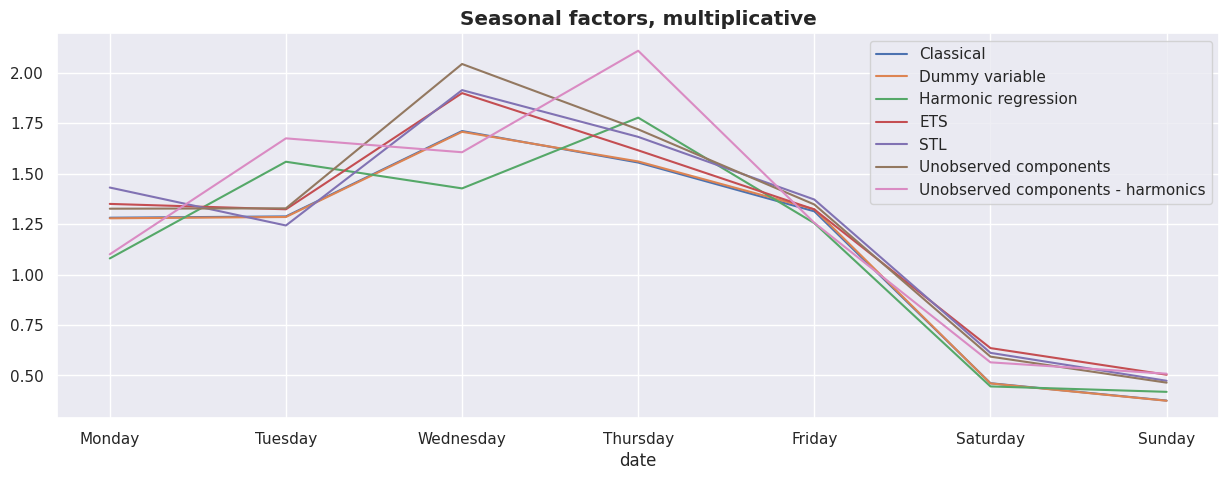

In [40]:
avg_seasonals = seasonals.groupby(seasonals.index.dayofweek).mean()
avg_seasonals.index = avg_seasonals.index.map(daysofweek)
ax = avg_seasonals.plot(figsize=(15, 5))
ax.set_title('Seasonal factors, multiplicative', fontsize='large', fontweight='bold');

#### Seasonal effects over time

To examine the seasonal effects over time, we will return to the polar seasonal plots of the form we used above. This time, however, we will not simply graph the seasonal effects for a single week, but we will graph the entire time series of seasonal effects. To give us a sense of the change over time, we will use a lighter color for weeks earlier in the sample and make each subsequent week slightly darker.

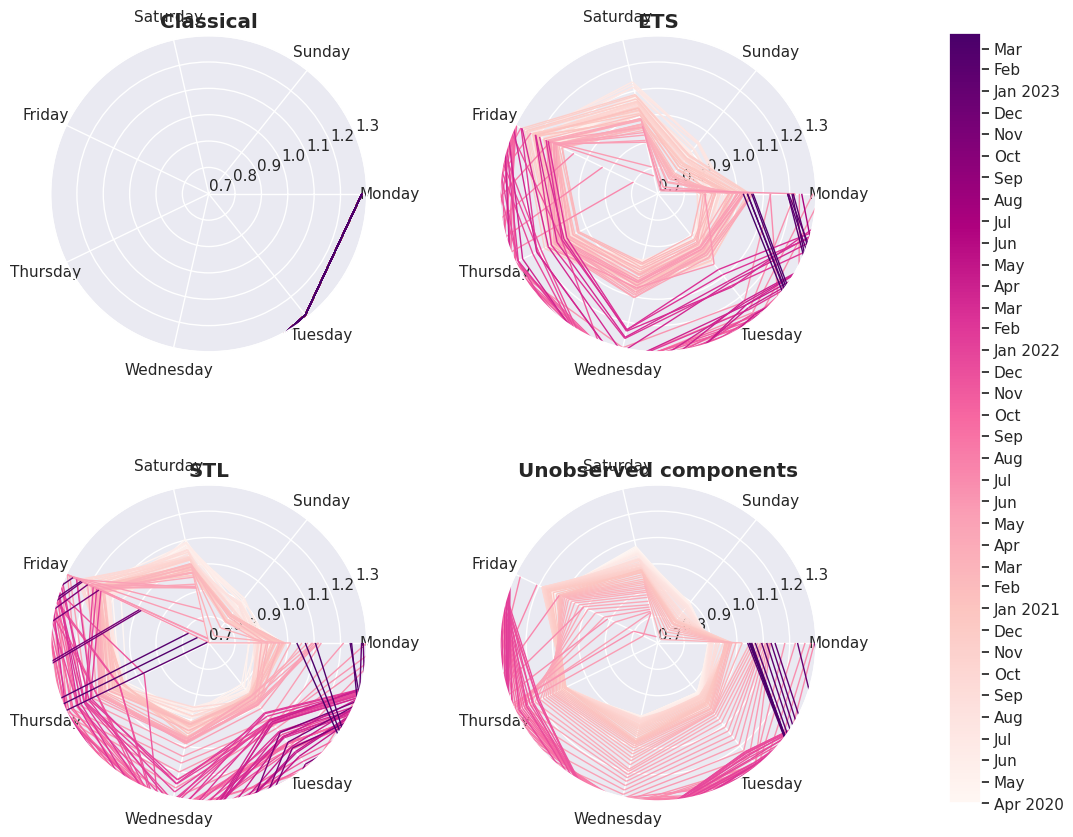

In [41]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

def add_polar_seasonal(s, ax):
    t = np.linspace(0, 20, len(seasonals))
    theta = (1 - (s.index.dayofweek / 7)) * 2 * np.pi
    r = s.values
    points = np.c_[theta, r].reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap('RdPu'),
                        norm=plt.Normalize(0, 20))
    lc.set_array(t)
    lc.set_linewidth(1)

    ax.add_collection(lc)

    ax.set_xticks((1 - np.arange(7) / 7) * 2 * np.pi)
    ax.set_xticklabels(daysofweek.values())
    ax.set_ylim(0.7, 1.3)
    ax.set_title(s.name, fontweight='bold', fontsize='large')

    return t, lc

# Create the figure and axes grid specification
fig = plt.figure(figsize=(12, 10))
gs1 = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.1], figure=fig)
ax1 = fig.add_subplot(gs1[0, 0], projection='polar')
ax2 = fig.add_subplot(gs1[0, 1], projection='polar')
ax3 = fig.add_subplot(gs1[1, 0], projection='polar')
ax4 = fig.add_subplot(gs1[1, 1], projection='polar')
ax_cb = fig.add_subplot(gs1[:, 2])

# Add the seasonal polar plots
add_polar_seasonal(seasonals['Classical'], ax1)
add_polar_seasonal(seasonals['ETS'], ax2)
add_polar_seasonal(seasonals['STL'], ax3)
t, lc = add_polar_seasonal(seasonals['Unobserved components'], ax4)

# Add the colorbar
cbar = fig.colorbar(lc, cax=ax_cb)

# Re-label the colorbar with readable dates
months = seasonals.resample('MS').first().index
iloc = [seasonals.index.get_loc(month.strftime('%Y-%m-%d')) for month in months]
cbar.ax.yaxis.set_ticks(t[iloc])
cbar.ax.yaxis.set_ticklabels([
    month.strftime('%b %Y' if (i == 0 or month.month == 1) else '%b')
    for i, month in enumerate(months)])

# Update the spacing between axes
gs1.update(wspace=0.6, hspace=0.4)

There are a number of things that we can observe from these graphs:

- Although the exponential smoothing model allows seasonal effects to vary over time in principle, in this case the model found that seasonal effects were quite stable (which is why they look similar to those from the Classical decomposition).
- Although we used the "robust" mode for the STL model, it was still relatively sensitive to the outliers (this is why part of this graph goes slightly outside of the plotted scale). In addition, seasonal factors exhibited a fair amount of change over the sample period.
- The unobserved components model allowed for a gradual change in the seasonal factors. This is particularly noticeable for Sundays, which originally were just a bit below average (the lighter colored lines), but were much farther below average by the end of the sample period (the darker colored lines).

### Seasonally adjusted data

One of the goals of this exercise was to produce seasonally adjusted data, which is to say we wanted to create a counterfactual series that eliminated the weekly seasonal variation. This is available in the `seasonally_adjusted` dataframe, created above.

Because the estimated seasonal effects were similar, these series are similar-looking when graphed (see the graph below).

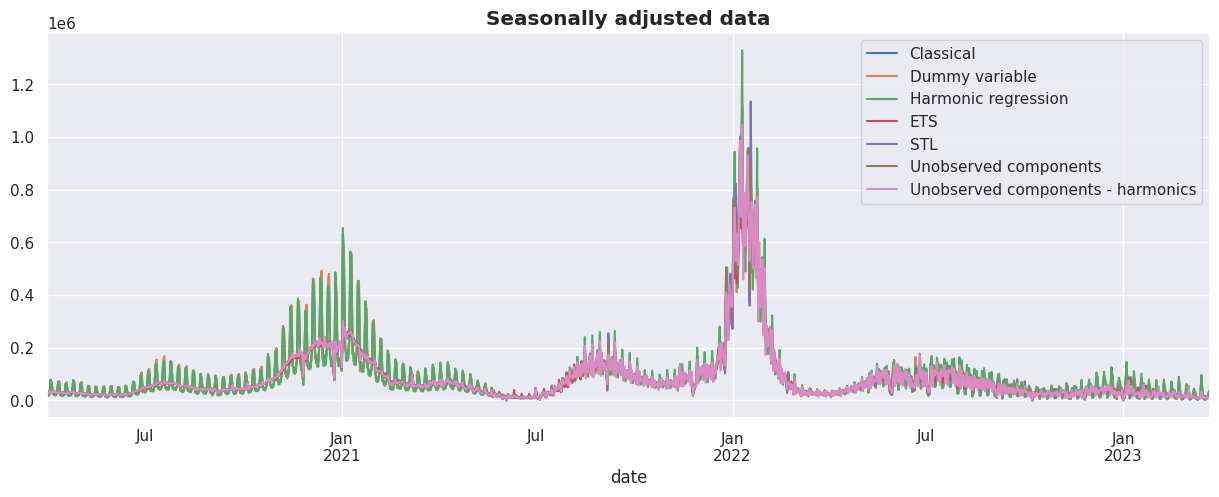

In [42]:
ax = seasonally_adjusted.plot(figsize=(15, 5))
ax.set_title('Seasonally adjusted data', fontsize='large', fontweight='bold');

However, there are differences between the results, which can be seen by zooming in on, for example, December 2020 through January 2021.

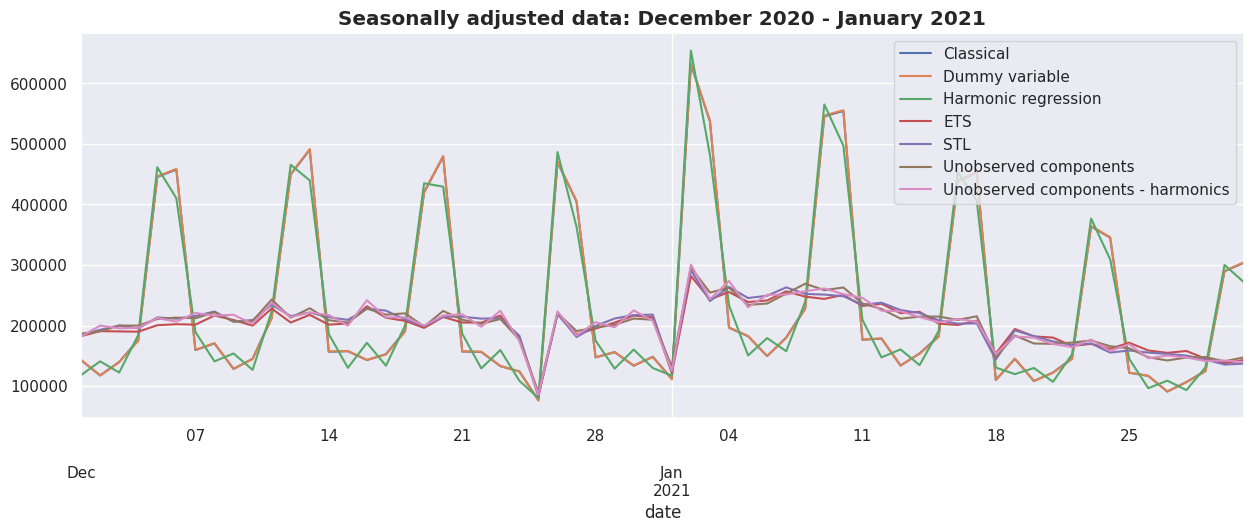

In [43]:
ax = seasonally_adjusted.loc['2020-12':'2021-01'].plot(figsize=(15, 5))
ax.set_title('Seasonally adjusted data: December 2020 - January 2021', fontsize='large', fontweight='bold');

### Trend

Returning to the "time series decomposition" concept, we can also examine the estimated trend components that were produced by our models.

The STL, Unobserved Components, and updated classical trend (which was updated after a first pass at accounting for outlier effects, see above) all display relatively smooth trends. They primarily differ in how they treat the periods near the holiday outliers, with the STL approach discounting more of the decline than the other two methods.

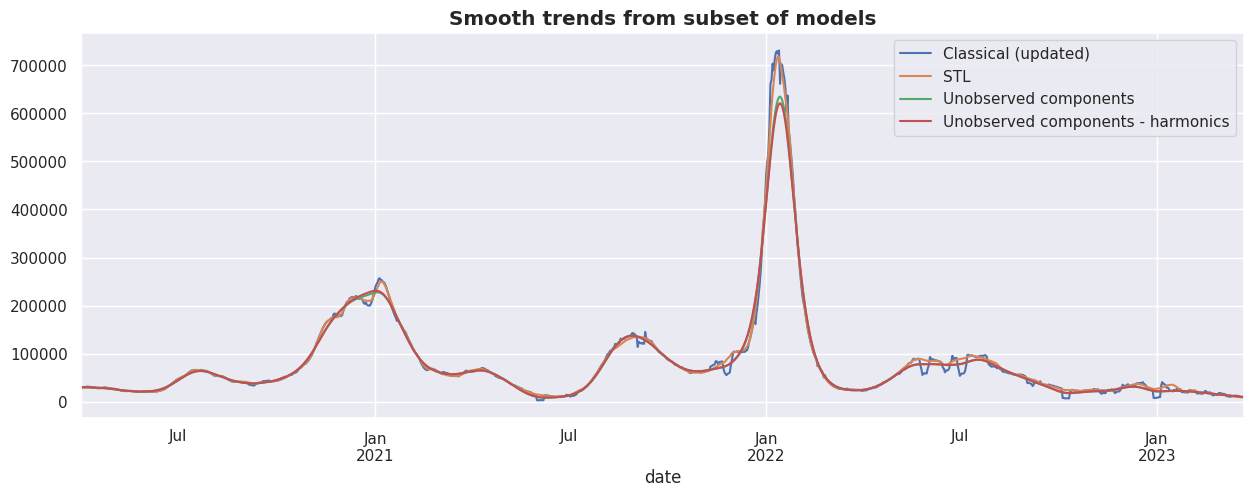

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))

trends[['Classical (updated)', 'STL', 'Unobserved components', 'Unobserved components - harmonics']].plot(ax=ax)
ax.set_title('Smooth trends from subset of models', fontsize='large', fontweight='bold');

Meanwhile, the original classical trend is quite sensitive to the outlier periods, while the trend from the exponential smoothing model is somewhat volatile.

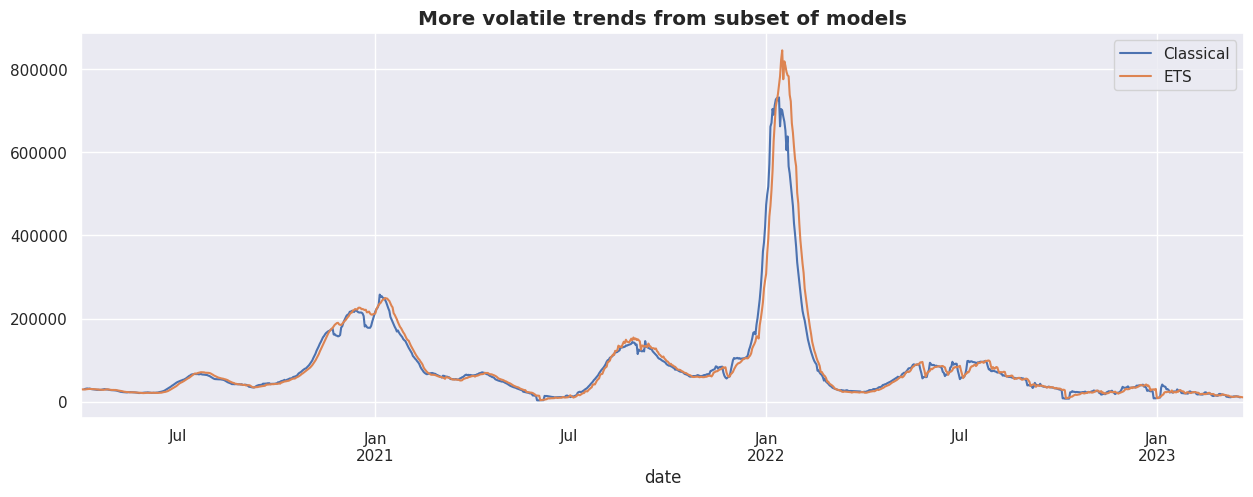

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))

trends[['Classical', 'ETS']].plot(ax=ax)
ax.set_title('More volatile trends from subset of models', fontsize='large', fontweight='bold');

## Other seasonal adjustment models

Of course even the models described above only represent a few of the possible models for estimating seasonal factors and seasonally adjusting time series.

Two popular / useful models that we did not include are:

1. [X-13ARIMA-SEATS](https://www.census.gov/srd/www/x13as/) is a commonly used (especially for U.S. government statistics) program produced by the U.S. Census Bureau. In this case, we can't use this program for seasonal adjustment, because it only supports monthly or quarterly data, and not daily data. However, given a monthly or quarterly dataset, this program can be called through Statsmodels via [`sm.tsa.x13_arima_analysis`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.x13.x13_arima_analysis.html).

2. [TBATS](https://otexts.com/fpp2/complexseasonality.html) is a relatively recent (circa 2011) econometric model that is particularly useful for data that exhibits multiple types of seasonality. In this case, we likely can't incorporate this functionality yet, since there isn't yet enough data to identify a monthly or annual seasonal effect. This model is not yet available in Statsmodels, but there is a Python implementation that can be found [on Github here](https://github.com/intive-DataScience/tbats).

## References

Brockwell, Peter J., Peter J. Brockwell, Richard A. Davis, and Richard A. Davis. Introduction to time series and forecasting. springer, 2016.

Cleveland, Robert B., William S. Cleveland, Jean E. McRae, and Irma Terpenning. "STL: A seasonal-trend decomposition." Journal of official statistics 6, no. 1 (1990): 3-73.

Commandeur, Jacques JF, and Siem Jan Koopman. An introduction to state space time series analysis. Oxford University Press, 2007.

De Livera, Alysha M., Rob J. Hyndman, and Ralph D. Snyder. "Forecasting time series with complex seasonal patterns using exponential smoothing." Journal of the American statistical association 106, no. 496 (2011): 1513-1527.

Durbin, James, and Siem Jan Koopman. Time series analysis by state space methods. Oxford university press, 2012.

Harvey, Andrew C. "Forecasting, structural time series models and the Kalman filter." (1990).

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. Accessed on 2021-01-24.

